In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.image import concat_imgs, mean_img 
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn.image import resample_to_img
from nilearn.datasets import load_mni152_brain_mask
from nilearn.image import binarize_img
from nilearn.image import resample_to_img
from nilearn.maskers import NiftiMasker
from nilearn.interfaces.fmriprep import load_confounds, load_confounds_strategy
from nltools.data import Brain_Data



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def CreateEventsDF_and_ContrastKeys(sub_events, events_duration):
    
    # Separate dataframe into run 1 and run 2. 
    sub_run1 = sub_events.iloc[:16, :]
    sub_run2 = sub_events.iloc[16:, :]
    sub_run1.reset_index(drop=True, inplace=True)
    sub_run2.reset_index(drop=True, inplace=True)

    # Create onsets array for each run.
    run1_trailer_onsets = np.array([12, 60, 108, 152, 196, 244, 288, 332, 376, 420, 468, 512, 560, 608, 656, 700])
    run2_trailer_onsets = np.array([12, 60, 108, 152, 200, 244, 288, 332, 380, 428, 476, 520, 568, 616, 660, 704])

    run1_trailer_onsets = run1_trailer_onsets - 8
    run2_trailer_onsets = run2_trailer_onsets - 8

    run1_trailer_labels = np.array(["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"])
    run2_trailer_labels = np.array(["rc3", "rh12", "rc1", "rh7", "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3", "rc7", "uh4"])

    run1_ITI_duration = np.array([6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2, 6, 6, 6, 2])
    run2_ITI_duration = np.array([2, 6, 6, 2, 6, 2, 2, 2, 6, 6, 6, 2, 6, 6, 2, 2])

    run1_watchQ_onsets = run1_trailer_onsets + 30   
    run2_watchQ_onsets = run2_trailer_onsets + 30

    run1_feelQ_onsets = run1_trailer_onsets + 30 + 4
    run2_feelQ_onsets = run2_trailer_onsets + 30 + 4

    run1_arousalQ_onsets = run1_trailer_onsets + 30 + 4 + 4
    run2_arousalQ_onsets = run2_trailer_onsets + 30 + 4 + 4

    run1_fixation_onsets = run1_trailer_onsets + 30 + 4 + 4 + 4
    run2_fixation_onsets = run2_trailer_onsets + 30 + 4 + 4 + 4

    run1_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])
    run2_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])

    for trailer_id in range(16):

        # Create a dictionary for each trailer with the onset, duration, and trial type. 
        run1_trailer = {"onset": run1_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run1_trailer_labels[trailer_id]}
        run2_trailer = {"onset": run2_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run2_trailer_labels[trailer_id]}

        run1_watchQ = {"onset": run1_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}
        run2_watchQ = {"onset": run2_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}

        run1_feelQ = {"onset": run1_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}
        run2_feelQ = {"onset": run2_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}

        run1_arousalQ = {"onset": run1_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}
        run2_arousalQ = {"onset": run2_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}

        run1_fixation = {"onset": run1_fixation_onsets[trailer_id], "duration": run1_ITI_duration[trailer_id], "trial_type": "fixation"}
        run2_fixation = {"onset": run2_fixation_onsets[trailer_id], "duration": run2_ITI_duration[trailer_id], "trial_type": "fixation"}

        # Add the dictionary to the dataframe. 
        run1_events_df.loc[len(run1_events_df.index)] = run1_trailer 
        run2_events_df.loc[len(run2_events_df.index)] = run2_trailer

        run1_events_df.loc[len(run1_events_df.index)] = run1_watchQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_watchQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_feelQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_feelQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_arousalQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_arousalQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_fixation
        run2_events_df.loc[len(run2_events_df.index)] = run2_fixation

    sub_events = [run1_events_df, run2_events_df]

    return sub_events

def CreateEventsDF_and_ContrastKeys_SEG(sub_events, segment_number):

    # All segments have a duartion of 3 TRs (6 sec).
    events_duration = 6
    
    # Adjust onset time depending on the segment number.
    if (segment_number == 1):
        segment_adjustment = 0
    elif (segment_number == 2):
        segment_adjustment = 6
    elif (segment_number == 3):
        segment_adjustment = 12
    elif (segment_number == 4):
        segment_adjustment = 18
    elif (segment_number == 5):
        segment_adjustment = 24
    else:
        print("Invalid segment number.")
        return None 


    # Separate dataframe into run 1 and run 2. 
    sub_run1 = sub_events.iloc[:16, :]
    sub_run2 = sub_events.iloc[16:, :]
    sub_run1.reset_index(drop=True, inplace=True)
    sub_run2.reset_index(drop=True, inplace=True)

    # Create onsets array for each run.
    run1_trailer_onsets = np.array([12, 60, 108, 152, 196, 244, 288, 332, 376, 420, 468, 512, 560, 608, 656, 700])
    run2_trailer_onsets = np.array([12, 60, 108, 152, 200, 244, 288, 332, 380, 428, 476, 520, 568, 616, 660, 704])

    run1_trailer_onsets = run1_trailer_onsets - 8 + segment_adjustment
    run2_trailer_onsets = run2_trailer_onsets - 8 + segment_adjustment

    run1_trailer_labels = np.array(["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"])
    run2_trailer_labels = np.array(["rc3", "rh12", "rc1", "rh7", "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3", "rc7", "uh4"])

    run1_ITI_duration = np.array([6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2, 6, 6, 6, 2])
    run2_ITI_duration = np.array([2, 6, 6, 2, 6, 2, 2, 2, 6, 6, 6, 2, 6, 6, 2, 2])

    run1_watchQ_onsets = run1_trailer_onsets + 30   
    run2_watchQ_onsets = run2_trailer_onsets + 30

    run1_feelQ_onsets = run1_trailer_onsets + 30 + 4
    run2_feelQ_onsets = run2_trailer_onsets + 30 + 4

    run1_arousalQ_onsets = run1_trailer_onsets + 30 + 4 + 4
    run2_arousalQ_onsets = run2_trailer_onsets + 30 + 4 + 4

    run1_fixation_onsets = run1_trailer_onsets + 30 + 4 + 4 + 4
    run2_fixation_onsets = run2_trailer_onsets + 30 + 4 + 4 + 4

    run1_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])
    run2_events_df = pd.DataFrame(columns=["onset", "duration", "trial_type"])

    for trailer_id in range(16):

        # Create a dictionary for each trailer with the onset, duration, and trial type. 
        run1_trailer = {"onset": run1_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run1_trailer_labels[trailer_id]}
        run2_trailer = {"onset": run2_trailer_onsets[trailer_id], "duration": events_duration, "trial_type": run2_trailer_labels[trailer_id]}

        run1_watchQ = {"onset": run1_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}
        run2_watchQ = {"onset": run2_watchQ_onsets[trailer_id], "duration": 4, "trial_type": "watchQ"}

        run1_feelQ = {"onset": run1_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}
        run2_feelQ = {"onset": run2_feelQ_onsets[trailer_id], "duration": 4, "trial_type": "feelQ"}

        run1_arousalQ = {"onset": run1_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}
        run2_arousalQ = {"onset": run2_arousalQ_onsets[trailer_id], "duration": 4, "trial_type": "arousalQ"}

        run1_fixation = {"onset": run1_fixation_onsets[trailer_id], "duration": run1_ITI_duration[trailer_id], "trial_type": "fixation"}
        run2_fixation = {"onset": run2_fixation_onsets[trailer_id], "duration": run2_ITI_duration[trailer_id], "trial_type": "fixation"}

        # Add the dictionary to the dataframe. 
        run1_events_df.loc[len(run1_events_df.index)] = run1_trailer 
        run2_events_df.loc[len(run2_events_df.index)] = run2_trailer

        run1_events_df.loc[len(run1_events_df.index)] = run1_watchQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_watchQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_feelQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_feelQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_arousalQ
        run2_events_df.loc[len(run2_events_df.index)] = run2_arousalQ

        run1_events_df.loc[len(run1_events_df.index)] = run1_fixation
        run2_events_df.loc[len(run2_events_df.index)] = run2_fixation

    sub_events = [run1_events_df, run2_events_df]

    return sub_events

In [4]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/la/Documents/Datasets


NAcc is binary mask with unique values:  [0. 1.]
AIns is binary mask with unique values:  [0. 1.]
vmPFC is binary mask with unique values:  [0. 1.]


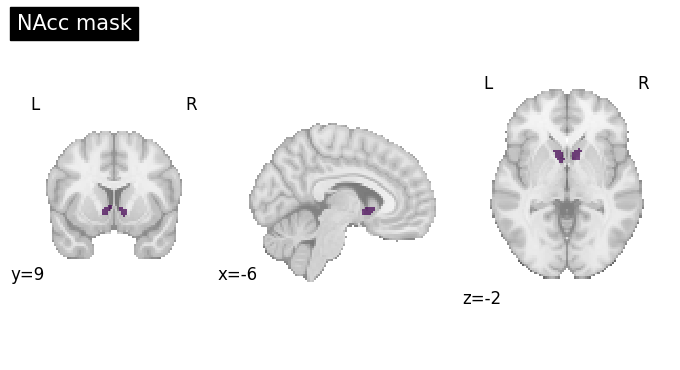

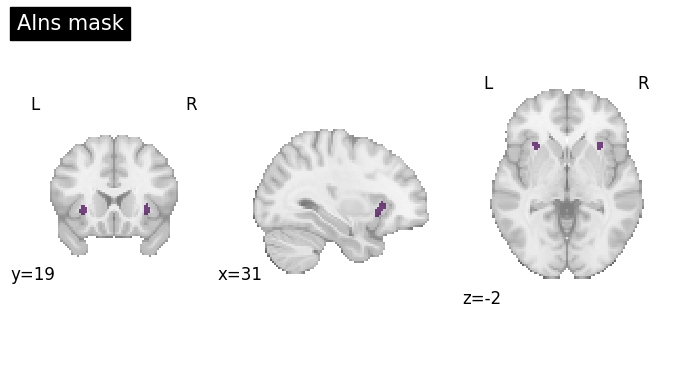

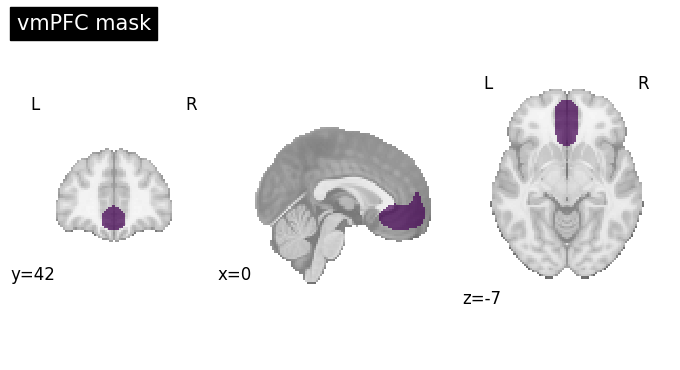

In [5]:
# Load masks from Plassman & Albuquerque study.
NAcc_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/NAc_bilateral.nii"
AIns_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/AI_bilateral.nii"
vmPFC_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/vmPFC_neurosynth_binary_resl.nii"

print("NAcc is binary mask with unique values: ", np.unique(nib.load(NAcc_path).get_fdata()))
print("AIns is binary mask with unique values: ", np.unique(nib.load(AIns_path).get_fdata()))
print("vmPFC is binary mask with unique values: ", np.unique(nib.load(vmPFC_path).get_fdata()))

# Create mask objects.
NAcc_masker = NiftiMasker(mask_img=NAcc_path, standardize=True, verbose=False).fit()
AIns_masker = NiftiMasker(mask_img=AIns_path, standardize=True, verbose=False).fit()
vmPFC_masker = NiftiMasker(mask_img=vmPFC_path, standardize=True, verbose=False).fit()

plot_roi(NAcc_masker.mask_img_, black_bg=False, title="NAcc mask", draw_cross=False, cmap="viridis")
plot_roi(AIns_masker.mask_img_, black_bg=False, title="AIns mask", draw_cross=False, cmap="viridis")
plot_roi(vmPFC_masker.mask_img_, black_bg=False, title="vmPFC mask", draw_cross=False, cmap="viridis")

In [6]:
#fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, facecolor='black') 

#output_file=
plot_roi(NAcc_masker.mask_img_, black_bg=True, title="", display_mode="z", cut_coords=1, draw_cross=False, cmap="autumn", output_file="NAccMask_Fig.png") # axes=axs[0]
plot_roi(AIns_masker.mask_img_, black_bg=True, title="", display_mode="z", cut_coords=1, draw_cross=False, cmap="autumn", output_file="AInsMask_Fig.png")
plot_roi(vmPFC_masker.mask_img_, black_bg=True, title="", display_mode="z", cut_coords=1, draw_cross=False, cmap="autumn", output_file="MPFCMask_Fig.png")


In [7]:
# from nilearn.datasets import get_data_dirs
# from nilearn.datasets.utils import fetch_file

# def download_collection(collection=None, data_dir=None, overwrite=False, resume=True, verbose=1):
#     """
#     Download images and metadata from Neurovault collection

#     Args:
#         collection (int, optional): collection id. Defaults to None.
#         data_dir (str, optional): data directory. Defaults to None.
#         overwrite (bool, optional): overwrite data directory. Defaults to False.
#         resume (bool, optional): resume download. Defaults to True.
#         verbose (int, optional): print diagnostic messages. Defaults to 1.

#     Returns:
#         (pd.DataFrame, list): (DataFrame of image metadata, list of files from downloaded collection)
#     """

#     if data_dir is None:
#         data_dir = get_dataset_dir(str(collection), data_dir=data_dir, verbose=verbose)

#     # Get collection Metadata
#     metadata = get_collection_image_metadata(collection=collection, data_dir=data_dir)

#     # Get images
#     files = []
#     for f in metadata["file"]:
#         files.append(
#             _fetch_file(
#                 f, data_dir, resume=resume, verbose=verbose, overwrite=overwrite
#             )
#         )

#     return (metadata, files)

# collection = 504
# dataset_name = "chang2015_pain"
# data_dir = None
# resume=True
# verbose=1
# data_dir = get_data_dirs(dataset_name, data_dir=data_dir, verbose=verbose)
# metadata, files = download_collection(collection=collection, data_dir=data_dir, resume=resume, verbose=verbose)

# Chang_pain_map = Brain_Data(data=files, X=metadata)

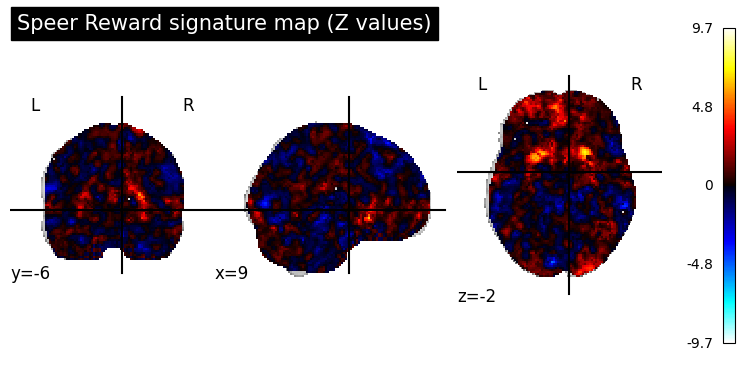

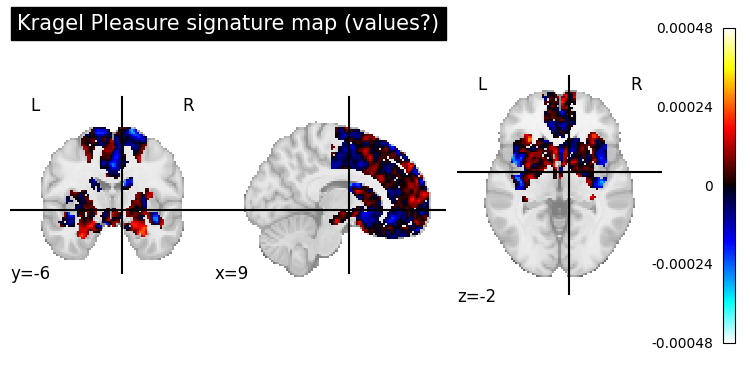

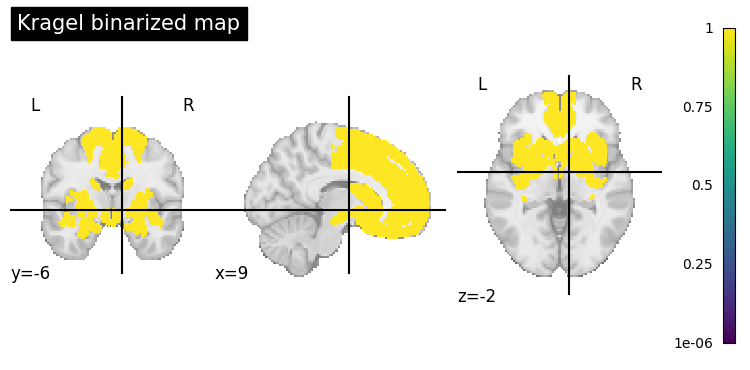

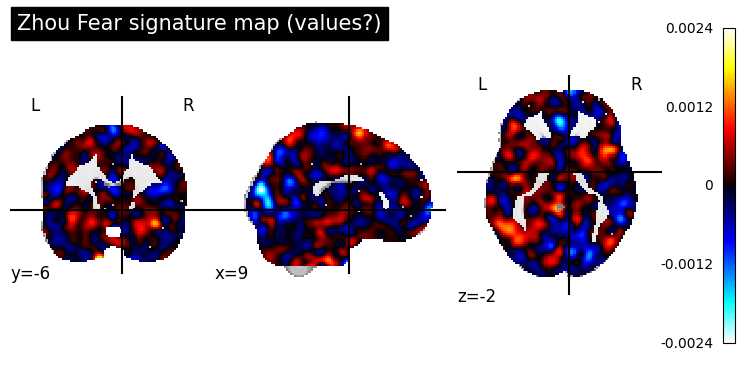

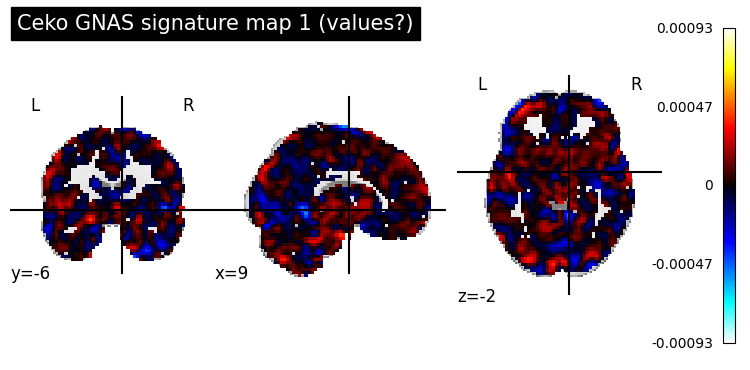

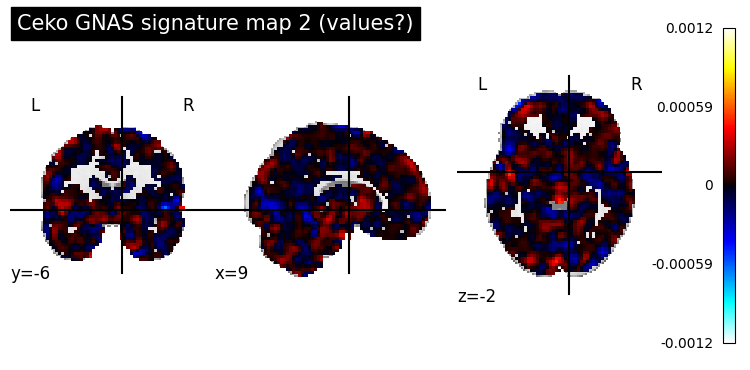

In [8]:
# Load signature maps. 

speer_reward_map_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/Signature_maps/SpeerREWARD_unthresholded_Z_map_1.nii.gz"
kragel_pleasure_map_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/Signature_maps/Kragel_PleasureSignature.nii.gz"
zhou_fear_map_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/Signature_maps/Zhou_VIFS.nii"
ceko_GNAS_map1_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/Signature_maps/PLS_CV_patterns/General_CV1.nii"
ceko_GNAS_map2_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/Signature_maps/PLS_CV_patterns/General_CV2.nii"

# Create binary image for Kragel signature map. 
kragel_bin_map = binarize_img(kragel_pleasure_map_path)
zhou_bin_map = binarize_img(zhou_fear_map_path)
ceko_GNAS_bin_map1 = binarize_img(ceko_GNAS_map1_path)
ceko_GNAS_bin_map2 = binarize_img(ceko_GNAS_map2_path)

# Create binary masker object. 
kragel_bin_map_masker = NiftiMasker(maps_img=kragel_bin_map, allow_overlap=True)
zhou_bin_map_masker = NiftiMasker(maps_img=zhou_bin_map, allow_overlap=True)
ceko_GNAS_bin_map1_masker = NiftiMasker(maps_img=ceko_GNAS_bin_map1, allow_overlap=True)
ceko_GNAS_bin_map2_masker = NiftiMasker(maps_img=ceko_GNAS_bin_map2, allow_overlap=True)

plot_stat_map(speer_reward_map_path, title="Speer Reward signature map (Z values)", cut_coords=[9, -6, -2])
plot_stat_map(kragel_pleasure_map_path, title="Kragel Pleasure signature map (values?)", cut_coords=[9, -6, -2])
plot_stat_map(kragel_bin_map, title="Kragel binarized map", cut_coords=[9, -6, -2], cmap="viridis")
plot_stat_map(zhou_fear_map_path, title="Zhou Fear signature map (values?)", cut_coords=[9, -6, -2])    
plot_stat_map(ceko_GNAS_map1_path, title="Ceko GNAS signature map 1 (values?)", cut_coords=[9, -6, -2])
plot_stat_map(ceko_GNAS_map2_path, title="Ceko GNAS signature map 2 (values?)", cut_coords=[9, -6, -2])




In [9]:
# Get list of participants.
neural_data_df = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation.csv"
neural_data = pd.read_csv(neural_data_df)
participants_list = neural_data["Participant"].unique().tolist()

all_participants_GLM_df = pd.DataFrame()

for sub_id in participants_list:

    # Load events data for current participant. 
    sub_events_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/" + sub_id + "/" + sub_id + "_processed_events.csv"
    sub_events = pd.read_csv(sub_events_path, sep='\,')

    sub_events_long = CreateEventsDF_and_ContrastKeys(sub_events, 30) 
    sub_events_seg1 = CreateEventsDF_and_ContrastKeys_SEG(sub_events, 1)
    sub_events_seg2 = CreateEventsDF_and_ContrastKeys_SEG(sub_events, 2)
    sub_events_seg3 = CreateEventsDF_and_ContrastKeys_SEG(sub_events, 3)
    sub_events_seg4 = CreateEventsDF_and_ContrastKeys_SEG(sub_events, 4)
    sub_events_seg5 = CreateEventsDF_and_ContrastKeys_SEG(sub_events, 5)

    trailers_run1 = np.array(["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"])
    trailers_run2 = np.array(["rc3", "rh12", "rc1", "rh7", "rc8", "uc3", "rh10", "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", "uh3", "rc7", "uh4"])

    # Load fMRI data for current participant.
    sub_run1_func = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_func_files = [sub_run1_func, sub_run2_func]

    # Load fMRI confounds for current participant.
    sub_run1_confounds = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Load mask file.
    sub_mask_run1 = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_mask_run2 = "MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    # Binarize sub mask.
    sub_mask_run1_bin = binarize_img(sub_mask_run1)
    sub_mask_run2_bin = binarize_img(sub_mask_run2)

    # Get confounds df for each run.
    sub_run1_confounds = pd.read_csv(sub_run1_confounds, sep='\t')
    sub_run2_confounds = pd.read_csv(sub_run2_confounds, sep='\t')

    simple_confounds = [
                        "rot_x", "rot_y", "rot_z", "trans_x", "trans_y", "trans_z",
                        "framewise_displacement", "white_matter", "csf", "csf_wm"
                        ]
    
    sub_run1_confounds = sub_run1_confounds[simple_confounds]
    sub_run2_confounds = sub_run2_confounds[simple_confounds]

    # Drop the first 4 TRs from the confounds.
    sub_run1_confounds = sub_run1_confounds.iloc[4:]
    sub_run2_confounds = sub_run2_confounds.iloc[4:]

    sub_run1_confounds = sub_run1_confounds.fillna(0) 
    sub_run2_confounds = sub_run2_confounds.fillna(0)

    sub_confound_files = [sub_run1_confounds, sub_run2_confounds]
    
    # # Get sample mask.
    confounds_run1, sample_mask_run1 = load_confounds(sub_run1_func, strategy=["motion", "high_pass", "scrub"], motion="power2", fd_threshold=0.30, scrub=0) 
    confounds_run2, sample_mask_run2 = load_confounds(sub_run2_func, strategy=["motion", "high_pass", "scrub"], motion="power2", fd_threshold=0.30, scrub=0) 

    # Adjust mask to match the new data range
    sample_mask_run1 = sample_mask_run1[sample_mask_run1 >= 4] - 4
    sample_mask_run2 = sample_mask_run2[sample_mask_run2 >= 4] - 4

    # Resample ROI masks to match subject's fMRI data.
    sub_func_data_r1 = nib.load(sub_func_files[0])
    sub_func_data_r2 = nib.load(sub_func_files[1])

    # Drop first 4 TRs.
    sub_run1_func_trim = sub_func_data_r2.slicer[:,:,:,4:]
    sub_run2_func_trim = sub_func_data_r2.slicer[:,:,:,4:]

    NAcc_masker_resampled_r1 = resample_to_img(NAcc_path, sub_func_data_r1, interpolation='nearest')
    AIns_masker_resampled_r1 = resample_to_img(AIns_path, sub_func_data_r1, interpolation='nearest')
    vmPFC_masker_resampled_r1 = resample_to_img(vmPFC_path, sub_func_data_r1, interpolation='nearest')

    NAcc_masker_resampled_r2 = resample_to_img(NAcc_path, sub_func_data_r2, interpolation='nearest')
    AIns_masker_resampled_r2 = resample_to_img(AIns_path, sub_func_data_r2, interpolation='nearest')
    vmPFC_masker_resampled_r2 = resample_to_img(vmPFC_path, sub_func_data_r2, interpolation='nearest')

    NAcc_masker_r1 = NiftiMasker(mask_img=NAcc_masker_resampled_r1, standardize=False, verbose=False).fit()
    AIns_masker_r1 = NiftiMasker(mask_img=AIns_masker_resampled_r1, standardize=False, verbose=False).fit()
    vmPFC_masker_r1 = NiftiMasker(mask_img=vmPFC_masker_resampled_r1, standardize=False, verbose=False).fit()

    NAcc_masker_r2 = NiftiMasker(mask_img=NAcc_masker_resampled_r2, standardize=False, verbose=False).fit()
    AIns_masker_r2 = NiftiMasker(mask_img=AIns_masker_resampled_r2, standardize=False, verbose=False).fit()
    vmPFC_masker_r2 = NiftiMasker(mask_img=vmPFC_masker_resampled_r2, standardize=False, verbose=False).fit()

    # Create first level model (for whole run).
    glm_run1_long = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')

    glm_run2_long = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    # Create first level model (for each segment).
    glm_run1_seg1 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run1_seg2 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run1_seg3 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run1_seg4 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run1_seg5 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run1_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run2_seg1 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run2_seg2 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run2_seg3 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run2_seg4 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')
    
    glm_run2_seg5 = FirstLevelModel(t_r=2.0,
                        slice_time_ref=0.0,
                        subject_label=sub_id,
                        standardize=True,
                        #minimize_memory=False,
                        mask_img=sub_mask_run2_bin, 
                        hrf_model='spm', #+ derivative
                        high_pass=1/360, 
                        drift_model='cosine',
                        smoothing_fwhm=4.0,
                        noise_model='ols')

    # Fit model to data.
    glm_run1_long.fit(sub_run1_func_trim, 
                       events=sub_events_long[0], 
                       confounds=sub_confound_files[0], 
                       sample_masks=sample_mask_run1)

    glm_run2_long.fit(sub_run2_func_trim,
                        events=sub_events_long[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)
    
    glm_run1_seg1.fit(sub_run1_func_trim, 
                       events=sub_events_seg1[0], 
                       confounds=sub_confound_files[0], 
                       sample_masks=sample_mask_run1)
    
    glm_run2_seg1.fit(sub_run2_func_trim,
                        events=sub_events_seg1[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)
    
    glm_run1_seg2.fit(sub_run1_func_trim,
                        events=sub_events_seg2[0], 
                        confounds=sub_confound_files[0], 
                        sample_masks=sample_mask_run1)
    
    glm_run2_seg2.fit(sub_run2_func_trim,
                        events=sub_events_seg2[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)
    
    glm_run1_seg3.fit(sub_run1_func_trim,
                        events=sub_events_seg3[0], 
                        confounds=sub_confound_files[0], 
                        sample_masks=sample_mask_run1)
    
    glm_run2_seg3.fit(sub_run2_func_trim,
                        events=sub_events_seg3[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)
    
    glm_run1_seg4.fit(sub_run1_func_trim,
                        events=sub_events_seg4[0], 
                        confounds=sub_confound_files[0], 
                        sample_masks=sample_mask_run1)
    
    glm_run2_seg4.fit(sub_run2_func_trim,
                        events=sub_events_seg4[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)
    
    glm_run1_seg5.fit(sub_run1_func_trim,
                        events=sub_events_seg5[0], 
                        confounds=sub_confound_files[0], 
                        sample_masks=sample_mask_run1)
    
    glm_run2_seg5.fit(sub_run2_func_trim,
                        events=sub_events_seg5[1], 
                        confounds=sub_confound_files[1], 
                        sample_masks=sample_mask_run2)  

    # Create dictionary to store results.
    result_dic = {}

    # Loop through each trailer.
    for run_id in range(len(trailers_run1)):

        # Compute contrast for 1st run.
        current_trailer_key_r1 = "+1*" + trailers_run1[run_id] + "-1*fixation" #+ "+1*" + trailers_run1[run_id] + "_derivative"  #+ "-1*fixation_derivative"
        current_trailer_contrast_r1_long = glm_run1_long.compute_contrast(current_trailer_key_r1, output_type="effect_size")
        current_trailer_contrast_seg1 = glm_run1_seg1.compute_contrast(current_trailer_key_r1, output_type="effect_size")
        current_trailer_contrast_seg2 = glm_run1_seg2.compute_contrast(current_trailer_key_r1, output_type="effect_size")
        current_trailer_contrast_seg3 = glm_run1_seg3.compute_contrast(current_trailer_key_r1, output_type="effect_size")
        current_trailer_contrast_seg4 = glm_run1_seg4.compute_contrast(current_trailer_key_r1, output_type="effect_size")
        current_trailer_contrast_seg5 = glm_run1_seg5.compute_contrast(current_trailer_key_r1, output_type="effect_size")

        # Get NAcc data.
        NAcc_data_run1_long = NAcc_masker_r1.transform(current_trailer_contrast_r1_long).mean()
        NAcc_data_run1_seg1 = NAcc_masker_r1.transform(current_trailer_contrast_seg1).mean()
        NAcc_data_run1_seg2 = NAcc_masker_r1.transform(current_trailer_contrast_seg2).mean()
        NAcc_data_run1_seg3 = NAcc_masker_r1.transform(current_trailer_contrast_seg3).mean()
        NAcc_data_run1_seg4 = NAcc_masker_r1.transform(current_trailer_contrast_seg4).mean()
        NAcc_data_run1_seg5 = NAcc_masker_r1.transform(current_trailer_contrast_seg5).mean()

        # Get AIns data.
        AIns_data_run1_long = AIns_masker_r1.transform(current_trailer_contrast_r1_long).mean()
        AIns_data_run1_seg1 = AIns_masker_r1.transform(current_trailer_contrast_seg1).mean()
        AIns_data_run1_seg2 = AIns_masker_r1.transform(current_trailer_contrast_seg2).mean()
        AIns_data_run1_seg3 = AIns_masker_r1.transform(current_trailer_contrast_seg3).mean()
        AIns_data_run1_seg4 = AIns_masker_r1.transform(current_trailer_contrast_seg4).mean()
        AIns_data_run1_seg5 = AIns_masker_r1.transform(current_trailer_contrast_seg5).mean()

        # Get vmPFC data.
        vmPFC_data_run1_long = vmPFC_masker_r1.transform(current_trailer_contrast_r1_long).mean()
        vmPFC_data_run1_seg1 = vmPFC_masker_r1.transform(current_trailer_contrast_seg1).mean()
        vmPFC_data_run1_seg2 = vmPFC_masker_r1.transform(current_trailer_contrast_seg2).mean()
        vmPFC_data_run1_seg3 = vmPFC_masker_r1.transform(current_trailer_contrast_seg3).mean()
        vmPFC_data_run1_seg4 = vmPFC_masker_r1.transform(current_trailer_contrast_seg4).mean()
        vmPFC_data_run1_seg5 = vmPFC_masker_r1.transform(current_trailer_contrast_seg5).mean()

        # Compute contrast for 2nd run.
        current_trailer_key_r2 = "+1*" + trailers_run2[run_id] + "-1*fixation" #"+1*" + trailers_run2[run_id] + "_derivative" + "-1*fixation" #+ "-1*fixation_derivative"
        current_trailer_contrast_r2_long = glm_run2_long.compute_contrast(current_trailer_key_r2, output_type="effect_size")
        current_trailer_contrast_seg1 = glm_run2_seg1.compute_contrast(current_trailer_key_r2, output_type="effect_size")
        current_trailer_contrast_seg2 = glm_run2_seg2.compute_contrast(current_trailer_key_r2, output_type="effect_size")
        current_trailer_contrast_seg3 = glm_run2_seg3.compute_contrast(current_trailer_key_r2, output_type="effect_size")
        current_trailer_contrast_seg4 = glm_run2_seg4.compute_contrast(current_trailer_key_r2, output_type="effect_size")
        current_trailer_contrast_seg5 = glm_run2_seg5.compute_contrast(current_trailer_key_r2, output_type="effect_size")

        # Get NAcc data.
        NAcc_data_run2_long = NAcc_masker_r2.transform(current_trailer_contrast_r2_long).mean()
        NAcc_data_run2_seg1 = NAcc_masker_r2.transform(current_trailer_contrast_seg1).mean()
        NAcc_data_run2_seg2 = NAcc_masker_r2.transform(current_trailer_contrast_seg2).mean()
        NAcc_data_run2_seg3 = NAcc_masker_r2.transform(current_trailer_contrast_seg3).mean()
        NAcc_data_run2_seg4 = NAcc_masker_r2.transform(current_trailer_contrast_seg4).mean()
        NAcc_data_run2_seg5 = NAcc_masker_r2.transform(current_trailer_contrast_seg5).mean()

        # Get AIns data.
        AIns_data_run2_long = AIns_masker_r2.transform(current_trailer_contrast_r2_long).mean()
        AIns_data_run2_seg1 = AIns_masker_r2.transform(current_trailer_contrast_seg1).mean()
        AIns_data_run2_seg2 = AIns_masker_r2.transform(current_trailer_contrast_seg2).mean()
        AIns_data_run2_seg3 = AIns_masker_r2.transform(current_trailer_contrast_seg3).mean()
        AIns_data_run2_seg4 = AIns_masker_r2.transform(current_trailer_contrast_seg4).mean()
        AIns_data_run2_seg5 = AIns_masker_r2.transform(current_trailer_contrast_seg5).mean()

        # Get vmPFC data.
        vmPFC_data_run2_long = vmPFC_masker_r2.transform(current_trailer_contrast_r2_long).mean()
        vmPFC_data_run2_seg1 = vmPFC_masker_r2.transform(current_trailer_contrast_seg1).mean()
        vmPFC_data_run2_seg2 = vmPFC_masker_r2.transform(current_trailer_contrast_seg2).mean()
        vmPFC_data_run2_seg3 = vmPFC_masker_r2.transform(current_trailer_contrast_seg3).mean()
        vmPFC_data_run2_seg4 = vmPFC_masker_r2.transform(current_trailer_contrast_seg4).mean()
        vmPFC_data_run2_seg5 = vmPFC_masker_r2.transform(current_trailer_contrast_seg5).mean()

        # Compute brain similarity to neuro map signatures. 
        # Resample map images to current subject brain space (should be MNI).
        speer_reward_map_obj_resmp_r1 = resample_to_img(speer_reward_map_path, sub_func_data_r1, interpolation="nearest")
        speer_reward_map_obj_resmp_r2 = resample_to_img(speer_reward_map_path, sub_func_data_r2, interpolation="nearest")

        kragel_pleasure_map_obj_resmp_r1 = resample_to_img(kragel_pleasure_map_path, sub_func_data_r1, interpolation="nearest")
        kragel_pleasure_map_obj_resmp_r2 = resample_to_img(kragel_pleasure_map_path, sub_func_data_r2, interpolation="nearest")

        zhou_fear_map_obj_resmp_r1 = resample_to_img(zhou_fear_map_path, sub_func_data_r1, interpolation="nearest")
        zhou_fear_map_obj_resmp_r2 = resample_to_img(zhou_fear_map_path, sub_func_data_r2, interpolation="nearest")

        ceko_GNAS_map1_obj_resmp_r1 = resample_to_img(ceko_GNAS_map1_path, sub_func_data_r1, interpolation="nearest")
        ceko_GNAS_map1_obj_resmp_r2 = resample_to_img(ceko_GNAS_map1_path, sub_func_data_r2, interpolation="nearest")

        ceko_GNAS_map2_obj_resmp_r1 = resample_to_img(ceko_GNAS_map2_path, sub_func_data_r1, interpolation="nearest")
        ceko_GNAS_map2_obj_resmp_r2 = resample_to_img(ceko_GNAS_map2_path, sub_func_data_r2, interpolation="nearest")

        # Create Brain_Data objects.
        speer_reward_map_obj_r1 = Brain_Data(speer_reward_map_obj_resmp_r1)
        speer_reward_map_obj_r2 = Brain_Data(speer_reward_map_obj_resmp_r2)
        kragel_pleasure_map_obj_r1 = Brain_Data(kragel_pleasure_map_obj_resmp_r1)
        kragel_pleasure_map_obj_r2 = Brain_Data(kragel_pleasure_map_obj_resmp_r2)
        zhou_fear_map_obj_r1 = Brain_Data(zhou_fear_map_obj_resmp_r1)
        zhou_fear_map_obj_r2 = Brain_Data(zhou_fear_map_obj_resmp_r2)
        ceko_GNAS_map1_obj_r1 = Brain_Data(ceko_GNAS_map1_obj_resmp_r1)
        ceko_GNAS_map1_obj_r2 = Brain_Data(ceko_GNAS_map1_obj_resmp_r2)
        ceko_GNAS_map2_obj_r1 = Brain_Data(ceko_GNAS_map2_obj_resmp_r1)
        ceko_GNAS_map2_obj_r2 = Brain_Data(ceko_GNAS_map2_obj_resmp_r2)

        # Compute Z-score maps for AVG, seg1 (onset), seg5 (offset).
        current_trailer_contrast_r1_long = glm_run1_long.compute_contrast(current_trailer_key_r1, output_type="z_score")
        current_trailer_contrast_r2_long = glm_run2_long.compute_contrast(current_trailer_key_r2, output_type="z_score")

        current_trailer_contrast_r1_seg1 = glm_run1_seg1.compute_contrast(current_trailer_key_r1, output_type="z_score")
        current_trailer_contrast_r2_seg1 = glm_run2_seg1.compute_contrast(current_trailer_key_r2, output_type="z_score")

        current_trailer_contrast_r1_seg5 = glm_run1_seg5.compute_contrast(current_trailer_key_r1, output_type="z_score")
        current_trailer_contrast_r2_seg5 = glm_run2_seg5.compute_contrast(current_trailer_key_r2, output_type="z_score")

        # Get similarity to Speer signature map. 
        trailer_r1_similarity_to_speer_AVG = speer_reward_map_obj_r1.similarity(current_trailer_contrast_r1_long, method='correlation')
        trailer_r2_similarity_to_speer_AVG = speer_reward_map_obj_r2.similarity(current_trailer_contrast_r2_long, method='correlation')

        trailer_r1_similarity_to_speer_seg1 = speer_reward_map_obj_r1.similarity(current_trailer_contrast_r1_seg1, method='correlation')
        trailer_r2_similarity_to_speer_seg1 = speer_reward_map_obj_r2.similarity(current_trailer_contrast_r2_seg1, method='correlation')    

        trailer_r1_similarity_to_speer_seg5 = speer_reward_map_obj_r1.similarity(current_trailer_contrast_r1_seg5, method='correlation')
        trailer_r2_similarity_to_speer_seg5 = speer_reward_map_obj_r2.similarity(current_trailer_contrast_r2_seg5, method='correlation')

        # Match voxels to the Kragel map.
        current_trailer_contrast_r1_long_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r1_seg1) 
        current_trailer_contrast_r2_seg1_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_kragel_vector = kragel_bin_map_masker.fit_transform(current_trailer_contrast_r2_seg5) 

        current_trailer_contrast_r1_long_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_kragel_vector = kragel_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r1_long_kragel_vector)
        current_trailer_contrast_r2_long_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r2_long_kragel_vector)

        current_trailer_contrast_r1_seg1_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r1_seg1_kragel_vector)
        current_trailer_contrast_r2_seg1_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r2_seg1_kragel_vector)

        current_trailer_contrast_r1_seg5_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r1_seg5_kragel_vector)
        current_trailer_contrast_r2_seg5_kragel_vol = kragel_bin_map_masker.inverse_transform(current_trailer_contrast_r2_seg5_kragel_vector)

        # Get similarity to Kragel signature map.
        trailer_r1_similarity_to_kragel_AVG = kragel_pleasure_map_obj_r1.similarity(current_trailer_contrast_r1_long_kragel_vol, method='correlation')
        trailer_r2_similarity_to_kragel_AVG = kragel_pleasure_map_obj_r2.similarity(current_trailer_contrast_r2_long_kragel_vol, method='correlation')

        trailer_r1_similarity_to_kragel_seg1 = kragel_pleasure_map_obj_r1.similarity(current_trailer_contrast_r1_seg1_kragel_vol, method='correlation')
        trailer_r2_similarity_to_kragel_seg1 = kragel_pleasure_map_obj_r2.similarity(current_trailer_contrast_r2_seg1_kragel_vol, method='correlation')

        trailer_r1_similarity_to_kragel_seg5 = kragel_pleasure_map_obj_r1.similarity(current_trailer_contrast_r1_seg5_kragel_vol, method='correlation')
        trailer_r2_similarity_to_kragel_seg5 = kragel_pleasure_map_obj_r2.similarity(current_trailer_contrast_r2_seg5_kragel_vol, method='correlation')

        # Match voxels to the Zhou map.
        current_trailer_contrast_r1_long_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_zhou_vector = zhou_bin_map_masker.fit_transform(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_zhou_vector = zhou_bin_map_masker.transform_single_imgs(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r1_long_zhou_vector)
        current_trailer_contrast_r2_long_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r2_long_zhou_vector)

        current_trailer_contrast_r1_seg1_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r1_seg1_zhou_vector)
        current_trailer_contrast_r2_seg1_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r2_seg1_zhou_vector)

        current_trailer_contrast_r1_seg5_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r1_seg5_zhou_vector)
        current_trailer_contrast_r2_seg5_zhou_vol = zhou_bin_map_masker.inverse_transform(current_trailer_contrast_r2_seg5_zhou_vector)

        # Get similarity to Zhou signature map.
        trailer_r1_similarity_to_zhou_AVG = zhou_fear_map_obj_r1.similarity(current_trailer_contrast_r1_long_zhou_vol, method='correlation')
        trailer_r2_similarity_to_zhou_AVG = zhou_fear_map_obj_r2.similarity(current_trailer_contrast_r2_long_zhou_vol, method='correlation')

        trailer_r1_similarity_to_zhou_seg1 = zhou_fear_map_obj_r1.similarity(current_trailer_contrast_r1_seg1_zhou_vol, method='correlation')
        trailer_r2_similarity_to_zhou_seg1 = zhou_fear_map_obj_r2.similarity(current_trailer_contrast_r2_seg1_zhou_vol, method='correlation')

        trailer_r1_similarity_to_zhou_seg5 = zhou_fear_map_obj_r1.similarity(current_trailer_contrast_r1_seg5_zhou_vol, method='correlation')
        trailer_r2_similarity_to_zhou_seg5 = zhou_fear_map_obj_r2.similarity(current_trailer_contrast_r2_seg5_zhou_vol, method='correlation')

        # Match voxels to the Ceko GNAS map 1.
        current_trailer_contrast_r1_long_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.fit_transform(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_ceko_GNAS1_vector = ceko_GNAS_bin_map1_masker.transform_single_imgs(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r1_long_ceko_GNAS1_vector)
        current_trailer_contrast_r2_long_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r2_long_ceko_GNAS1_vector)

        current_trailer_contrast_r1_seg1_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r1_seg1_ceko_GNAS1_vector)
        current_trailer_contrast_r2_seg1_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r2_seg1_ceko_GNAS1_vector)

        current_trailer_contrast_r1_seg5_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r1_seg5_ceko_GNAS1_vector)
        current_trailer_contrast_r2_seg5_ceko_GNAS1_vol = ceko_GNAS_bin_map1_masker.inverse_transform(current_trailer_contrast_r2_seg5_ceko_GNAS1_vector)

        # Get similarity to Ceko GNAS signature map 1.
        trailer_r1_similarity_to_ceko_GNAS1_AVG = ceko_GNAS_map1_obj_r1.similarity(current_trailer_contrast_r1_long_ceko_GNAS1_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS1_AVG = ceko_GNAS_map1_obj_r2.similarity(current_trailer_contrast_r2_long_ceko_GNAS1_vol, method='correlation')

        trailer_r1_similarity_to_ceko_GNAS1_seg1 = ceko_GNAS_map1_obj_r1.similarity(current_trailer_contrast_r1_seg1_ceko_GNAS1_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS1_seg1 = ceko_GNAS_map1_obj_r2.similarity(current_trailer_contrast_r2_seg1_ceko_GNAS1_vol, method='correlation')

        trailer_r1_similarity_to_ceko_GNAS1_seg5 = ceko_GNAS_map1_obj_r1.similarity(current_trailer_contrast_r1_seg5_ceko_GNAS1_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS1_seg5 = ceko_GNAS_map1_obj_r2.similarity(current_trailer_contrast_r2_seg5_ceko_GNAS1_vol, method='correlation')

        # Match voxels to the Ceko GNAS map 2.
        current_trailer_contrast_r1_long_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.fit_transform(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r1_long)
        current_trailer_contrast_r2_long_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r2_long)

        current_trailer_contrast_r1_seg1_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r1_seg1)
        current_trailer_contrast_r2_seg1_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r2_seg1)

        current_trailer_contrast_r1_seg5_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r1_seg5)
        current_trailer_contrast_r2_seg5_ceko_GNAS2_vector = ceko_GNAS_bin_map2_masker.transform_single_imgs(current_trailer_contrast_r2_seg5)

        current_trailer_contrast_r1_long_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r1_long_ceko_GNAS2_vector)
        current_trailer_contrast_r2_long_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r2_long_ceko_GNAS2_vector)

        current_trailer_contrast_r1_seg1_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r1_seg1_ceko_GNAS2_vector)
        current_trailer_contrast_r2_seg1_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r2_seg1_ceko_GNAS2_vector)

        current_trailer_contrast_r1_seg5_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r1_seg5_ceko_GNAS2_vector)
        current_trailer_contrast_r2_seg5_ceko_GNAS2_vol = ceko_GNAS_bin_map2_masker.inverse_transform(current_trailer_contrast_r2_seg5_ceko_GNAS2_vector)

        # Get similarity to Ceko GNAS signature map 2.
        trailer_r1_similarity_to_ceko_GNAS2_AVG = ceko_GNAS_map2_obj_r1.similarity(current_trailer_contrast_r1_long_ceko_GNAS2_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS2_AVG = ceko_GNAS_map2_obj_r2.similarity(current_trailer_contrast_r2_long_ceko_GNAS2_vol, method='correlation')

        trailer_r1_similarity_to_ceko_GNAS2_seg1 = ceko_GNAS_map2_obj_r1.similarity(current_trailer_contrast_r1_seg1_ceko_GNAS2_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS2_seg1 = ceko_GNAS_map2_obj_r2.similarity(current_trailer_contrast_r2_seg1_ceko_GNAS2_vol, method='correlation')

        trailer_r1_similarity_to_ceko_GNAS2_seg5 = ceko_GNAS_map2_obj_r1.similarity(current_trailer_contrast_r1_seg5_ceko_GNAS2_vol, method='correlation')
        trailer_r2_similarity_to_ceko_GNAS2_seg5 = ceko_GNAS_map2_obj_r2.similarity(current_trailer_contrast_r2_seg5_ceko_GNAS2_vol, method='correlation')

        # Append to dictionary.
        result_dic[trailers_run1[run_id]] = {"NAcc_GLM_long": NAcc_data_run1_long, "AIns_GLM_long": AIns_data_run1_long, "vmPFC_GLM_long": vmPFC_data_run1_long, 
                                            "NAcc_GLM_seg1": NAcc_data_run1_seg1, "AIns_GLM_seg1": AIns_data_run1_seg1, "vmPFC_GLM_seg1": vmPFC_data_run1_seg1,
                                            "NAcc_GLM_seg2": NAcc_data_run1_seg2, "AIns_GLM_seg2": AIns_data_run1_seg2, "vmPFC_GLM_seg2": vmPFC_data_run1_seg2,
                                            "NAcc_GLM_seg3": NAcc_data_run1_seg3, "AIns_GLM_seg3": AIns_data_run1_seg3, "vmPFC_GLM_seg3": vmPFC_data_run1_seg3,
                                            "NAcc_GLM_seg4": NAcc_data_run1_seg4, "AIns_GLM_seg4": AIns_data_run1_seg4, "vmPFC_GLM_seg4": vmPFC_data_run1_seg4,
                                            "NAcc_GLM_seg5": NAcc_data_run1_seg5, "AIns_GLM_seg5": AIns_data_run1_seg5, "vmPFC_GLM_seg5": vmPFC_data_run1_seg5, 
                                            "Sim_Speer_AVG": trailer_r1_similarity_to_speer_AVG, "Sim_Kragel_AVG": trailer_r1_similarity_to_kragel_AVG, "Sim_Zhou_AVG": trailer_r1_similarity_to_zhou_AVG,
                                            "Sim_Ceko_GNAS1_AVG": trailer_r1_similarity_to_ceko_GNAS1_AVG, "Sim_Ceko_GNAS2_AVG": trailer_r1_similarity_to_ceko_GNAS2_AVG, 
                                            "Sim_Speer_seg1": trailer_r1_similarity_to_speer_seg1, "Sim_Kragel_seg1": trailer_r1_similarity_to_kragel_seg1, "Sim_Zhou_seg1": trailer_r1_similarity_to_zhou_seg1,
                                            "Sim_Ceko_GNAS1_seg1": trailer_r1_similarity_to_ceko_GNAS1_seg1, "Sim_Ceko_GNAS2_seg1": trailer_r1_similarity_to_ceko_GNAS2_seg1, 
                                            "Sim_Speer_seg5": trailer_r1_similarity_to_speer_seg5, "Sim_Kragel_seg5": trailer_r1_similarity_to_kragel_seg5, "Sim_Zhou_seg5": trailer_r1_similarity_to_zhou_seg5,
                                            "Sim_Ceko_GNAS1_seg5": trailer_r1_similarity_to_ceko_GNAS1_seg5, "Sim_Ceko_GNAS2_seg5": trailer_r1_similarity_to_ceko_GNAS2_seg5}
        
        result_dic[trailers_run2[run_id]] = {"NAcc_GLM_long": NAcc_data_run2_long, "AIns_GLM_long": AIns_data_run2_long, "vmPFC_GLM_long": vmPFC_data_run2_long,
                                            "NAcc_GLM_seg1": NAcc_data_run2_seg1, "AIns_GLM_seg1": AIns_data_run2_seg1, "vmPFC_GLM_seg1": vmPFC_data_run2_seg1,
                                            "NAcc_GLM_seg2": NAcc_data_run2_seg2, "AIns_GLM_seg2": AIns_data_run2_seg2, "vmPFC_GLM_seg2": vmPFC_data_run2_seg2,
                                            "NAcc_GLM_seg3": NAcc_data_run2_seg3, "AIns_GLM_seg3": AIns_data_run2_seg3, "vmPFC_GLM_seg3": vmPFC_data_run2_seg3,
                                            "NAcc_GLM_seg4": NAcc_data_run2_seg4, "AIns_GLM_seg4": AIns_data_run2_seg4, "vmPFC_GLM_seg4": vmPFC_data_run2_seg4,
                                            "NAcc_GLM_seg5": NAcc_data_run2_seg5, "AIns_GLM_seg5": AIns_data_run2_seg5, "vmPFC_GLM_seg5": vmPFC_data_run2_seg5, 
                                            "Sim_Speer_AVG": trailer_r2_similarity_to_speer_AVG, "Sim_Kragel_AVG": trailer_r2_similarity_to_kragel_AVG, "Sim_Zhou_AVG": trailer_r2_similarity_to_zhou_AVG,
                                            "Sim_Ceko_GNAS1_AVG": trailer_r2_similarity_to_ceko_GNAS1_AVG, "Sim_Ceko_GNAS2": trailer_r2_similarity_to_ceko_GNAS2_AVG, 
                                            "Sim_Speer_seg1": trailer_r2_similarity_to_speer_seg1, "Sim_Kragel_seg1": trailer_r2_similarity_to_kragel_seg1, "Sim_Zhou_seg1": trailer_r2_similarity_to_zhou_seg1,
                                            "Sim_Ceko_GNAS1_seg1": trailer_r2_similarity_to_ceko_GNAS1_seg1, "Sim_Ceko_GNAS2_seg1": trailer_r2_similarity_to_ceko_GNAS2_seg1,
                                            "Sim_Speer_seg5": trailer_r2_similarity_to_speer_seg5, "Sim_Kragel_seg5": trailer_r2_similarity_to_kragel_seg5, "Sim_Zhou_seg5": trailer_r2_similarity_to_zhou_seg5,
                                            "Sim_Ceko_GNAS1_seg5": trailer_r2_similarity_to_ceko_GNAS1_seg5, "Sim_Ceko_GNAS2_seg5": trailer_r2_similarity_to_ceko_GNAS2_seg5}
                                            

    results_df = pd.DataFrame(result_dic).T
    results_df.reset_index(inplace=True)
    results_df.rename(columns={"index": "Trailer"}, inplace=True)

    # Add participant ID to dataframe.
    results_df["Participant"] = sub_id

    # Save results to csv.
    results_df.to_csv("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/" + sub_id + "/" + sub_id + "_GLM.csv", index=False)

    all_participants_GLM_df = pd.concat([all_participants_GLM_df, results_df], axis=0)
    print("Done with participant: ", sub_id)
    


Done with participant:  sub-01
Done with participant:  sub-02
Done with participant:  sub-03
Done with participant:  sub-04
Done with participant:  sub-08
Done with participant:  sub-09
Done with participant:  sub-10
Done with participant:  sub-11
Done with participant:  sub-12
Done with participant:  sub-13
Done with participant:  sub-14
Done with participant:  sub-15
Done with participant:  sub-16
Done with participant:  sub-17
Done with participant:  sub-18
Done with participant:  sub-19
Done with participant:  sub-21
Done with participant:  sub-22
Done with participant:  sub-23
Done with participant:  sub-25
Done with participant:  sub-26
Done with participant:  sub-27
Done with participant:  sub-28
Done with participant:  sub-29
Done with participant:  sub-30
Done with participant:  sub-31
Done with participant:  sub-32
Done with participant:  sub-33
Done with participant:  sub-34
Done with participant:  sub-35
Done with participant:  sub-36
Done with participant:  sub-37


In [13]:
# Save data to csv.
all_participants_GLM_df.to_csv("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_GLM.csv", index=False)
all_participants_GLM_df.head()

,Trailer,NAcc_GLM_long,AIns_GLM_long,vmPFC_GLM_long,NAcc_GLM_seg1,AIns_GLM_seg1,vmPFC_GLM_seg1,NAcc_GLM_seg2,AIns_GLM_seg2,vmPFC_GLM_seg2,...,Sim_Zhou_seg1,Sim_Ceko_GNAS1_seg1,Sim_Ceko_GNAS2_seg1,Sim_Speer_seg5,Sim_Kragel_seg5,Sim_Zhou_seg5,Sim_Ceko_GNAS1_seg5,Sim_Ceko_GNAS2_seg5,Sim_Ceko_GNAS2,Participant
0,rh6,0.006651,-0.075936,0.242234,0.639972,0.152733,1.059339,0.107801,-0.231401,0.605356,...,0.02954749132929265,-0.025011101009101925,-0.02584552208479666,-0.06659805229458511,-0.0012683948793155747,-0.04071218871170703,0.03181932487277109,0.03777340482985568,NaN,sub-01
1,rc3,0.129216,0.22452,0.456898,0.45968,0.150713,0.993489,0.072913,-0.150212,0.712076,...,0.017055678479752846,-0.013382436248669059,-0.029732647071695248,-0.07094391164088118,0.013171911685625587,-0.010922376769872337,0.02670261615122425,0.02052565337376523,-0.010761649577186796,sub-01
2,uh1,0.126909,-0.036938,0.051978,0.765529,-0.171904,0.811814,0.203985,-0.24151,0.103067,...,0.015642545461874165,0.002686358099581905,0.016118193419713243,-0.06496363090782677,-0.0036118731134413286,0.05280594263856881,0.02407032153612767,0.036441646969842326,NaN,sub-01
3,rh12,-0.128326,0.12658,-0.203784,0.09658,-0.272004,-0.098386,-0.268311,-0.299225,-0.357318,...,-0.01669689444029905,-0.0029559289326099277,-0.005773300590640023,-0.043432368915168475,-0.017300507244399153,0.022470843572592804,0.01693615691321319,0.014827003154423517,0.009559284791652689,sub-01
4,rc2,0.264281,0.324735,0.888858,0.177079,-0.447599,0.879473,0.21213,-0.220525,0.417249,...,-0.033894546475894585,-0.007843825271387253,0.008693489585723939,0.011330029726203613,0.011759411658833954,-0.014825854712715959,0.015716022106398324,0.030278048766956667,NaN,sub-01


In [11]:
# Create onsets array for each run.
# run1_trailer_onsets = np.array([12, 60, 108, 156, 200, 244, 292, 336, 380, 424, 468, 516, 560, 608, 656, 704])   
# run2_trailer_onsets = np.array([12, 56, 104, 152, 196, 244, 288, 332, 376, 424, 472, 520, 564, 612, 660, 704])

# run1_watchQ_onsets = run1_trailer_onsets + 30   
# run2_watchQ_onsets = run2_trailer_onsets + 30

# run1_feelQ_onsets = run1_trailer_onsets + 30 + 4
# run2_feelQ_onsets = run2_trailer_onsets + 30 + 4

# run1_arousalQ_onsets = run1_trailer_onsets + 30 + 4 + 4
# run2_arousalQ_onsets = run2_trailer_onsets + 30 + 4 + 4

# run1_fixation_onsets = run1_trailer_onsets + 30 + 4 + 4 + 4
# run2_fixation_onsets = run2_trailer_onsets + 30 + 4 + 4 + 4





In [12]:
all_participants_GLM_df.head()

,Trailer,NAcc_GLM_long,AIns_GLM_long,vmPFC_GLM_long,NAcc_GLM_seg1,AIns_GLM_seg1,vmPFC_GLM_seg1,NAcc_GLM_seg2,AIns_GLM_seg2,vmPFC_GLM_seg2,...,Sim_Zhou_seg1,Sim_Ceko_GNAS1_seg1,Sim_Ceko_GNAS2_seg1,Sim_Speer_seg5,Sim_Kragel_seg5,Sim_Zhou_seg5,Sim_Ceko_GNAS1_seg5,Sim_Ceko_GNAS2_seg5,Sim_Ceko_GNAS2,Participant
0,rh6,0.006651,-0.075936,0.242234,0.639972,0.152733,1.059339,0.107801,-0.231401,0.605356,...,0.02954749132929265,-0.025011101009101925,-0.02584552208479666,-0.06659805229458511,-0.0012683948793155747,-0.04071218871170703,0.03181932487277109,0.03777340482985568,NaN,sub-01
1,rc3,0.129216,0.22452,0.456898,0.45968,0.150713,0.993489,0.072913,-0.150212,0.712076,...,0.017055678479752846,-0.013382436248669059,-0.029732647071695248,-0.07094391164088118,0.013171911685625587,-0.010922376769872337,0.02670261615122425,0.02052565337376523,-0.010761649577186796,sub-01
2,uh1,0.126909,-0.036938,0.051978,0.765529,-0.171904,0.811814,0.203985,-0.24151,0.103067,...,0.015642545461874165,0.002686358099581905,0.016118193419713243,-0.06496363090782677,-0.0036118731134413286,0.05280594263856881,0.02407032153612767,0.036441646969842326,NaN,sub-01
3,rh12,-0.128326,0.12658,-0.203784,0.09658,-0.272004,-0.098386,-0.268311,-0.299225,-0.357318,...,-0.01669689444029905,-0.0029559289326099277,-0.005773300590640023,-0.043432368915168475,-0.017300507244399153,0.022470843572592804,0.01693615691321319,0.014827003154423517,0.009559284791652689,sub-01
4,rc2,0.264281,0.324735,0.888858,0.177079,-0.447599,0.879473,0.21213,-0.220525,0.417249,...,-0.033894546475894585,-0.007843825271387253,0.008693489585723939,0.011330029726203613,0.011759411658833954,-0.014825854712715959,0.015716022106398324,0.030278048766956667,NaN,sub-01
